In [4]:
# Clone the YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
# Change directory to YOLOv5
%cd yolov5
# Install required dependencies
!pip install -r requirements.txt

[WinError 2] The system cannot find the file specified: 'yolov5'
c:\Users\cheng\Documents\VSC\Higher_level_CV\Examination_project


'git' is not recognized as an internal or external command,
operable program or batch file.
C:\Users\cheng\AppData\Roaming\Python\Python39\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [5]:
import torch

# Load a pretrained YOLOv5 model from the cloned repository
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-11-15 Python-3.9.10 torch-2.5.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [6]:
import os
from PIL import Image
import torch

# Define paths
base_image_dir = 'split_data_for_YOLO_finetuning'  # Main directory containing 'train', 'validation', 'test'
output_label_dir = 'labeled_data_for_YOLO_finetuning'  # Directory to save generated labels
os.makedirs(output_label_dir, exist_ok=True)

# Loop through each split folder
for split in ['train', 'validation', 'test']:
    split_path = os.path.join(base_image_dir, split)
    split_output_path = os.path.join(output_label_dir, split)
    os.makedirs(split_output_path, exist_ok=True)

    # Loop through each class folder in the split
    for class_folder in os.listdir(split_path):
        class_folder_path = os.path.join(split_path, class_folder)
        if os.path.isdir(class_folder_path):
            # Make a corresponding folder in the output labels directory
            class_output_dir = os.path.join(split_output_path, class_folder)
            os.makedirs(class_output_dir, exist_ok=True)

            # Loop through each image in the class folder
            for image_file in os.listdir(class_folder_path):
                if image_file.endswith('.jpg') or image_file.endswith('.png'):
                    # Load the image
                    img_path = os.path.join(class_folder_path, image_file)
                    img = Image.open(img_path)
                    width, height = img.size  # Get image dimensions

                    # Run YOLOv5 inference
                    results = model(img)
                    
                    # Extract bounding boxes and save in YOLO format
                    label_filename = os.path.splitext(image_file)[0] + ".txt"
                    label_path = os.path.join(class_output_dir, label_filename)
                    
                    with open(label_path, "w") as f:
                        for *box, conf, cls in results.xywh[0]:  # YOLOv5 outputs in (x_center, y_center, width, height)
                            # Clone tensor values to avoid inplace modification error
                            x_center, y_center, box_width, box_height = [b.clone().item() for b in box]
                            class_id = int(cls)  # Get the class ID
                            
                            # Normalize coordinates to [0, 1] range
                            x_center /= width
                            y_center /= height
                            box_width /= width
                            box_height /= height
                            
                            # Write bounding box to label file in YOLO format
                            f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

print("Inference completed, and labels saved for each image in respective class folders.")



C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models

Inference completed, and labels saved for each image in respective class folders.


C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [ ]:
import os
import shutil

# Paths to image and label directories
image_base_dir = 'split_data_for_YOLO_finetuning'
label_base_dir = 'labeled_data_for_YOLO_finetuning'

# Iterate over train, validation, and test sets
for split in ['train', 'validation', 'test']:
    image_split_dir = os.path.join(image_base_dir, split)
    label_split_dir = os.path.join(label_base_dir, split)

    # Iterate through each class folder
    for class_folder in os.listdir(image_split_dir):
        image_class_dir = os.path.join(image_split_dir, class_folder)
        label_class_dir = os.path.join(label_split_dir, class_folder)

        if os.path.isdir(image_class_dir) and os.path.isdir(label_class_dir):
            # Create corresponding label folder under image folder if not already exists
            os.makedirs(image_class_dir, exist_ok=True)

            # Move each label file to the image folder
            for label_file in os.listdir(label_class_dir):
                label_path = os.path.join(label_class_dir, label_file)
                target_path = os.path.join(image_class_dir, label_file)
                shutil.copy(label_path, target_path)

print("Labels have been copied to match the YOLOv5 structure.")

In [10]:
!python ./yolov5/train.py --img 640 --batch 16 --epochs 100 --data custom_dataset.yaml --weights yolov5s.pt --project FineTunedModel --name FruitFreshnessDetection


python: can't open file 'c:\Users\cheng\Documents\VSC\Higher_level_CV\Examination_project\yolov5\train.py': [Errno 2] No such file or directory


In [14]:
!git clone https://github.com/ultralytics/yolov5.git


'git' is not recognized as an internal or external command,
operable program or batch file.


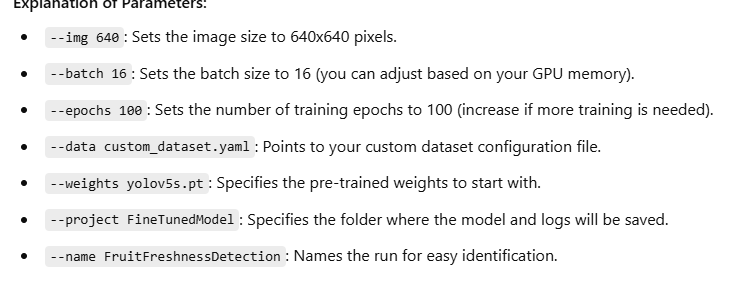

In [9]:
# model eval 
!python path/to/yolov5/val.py --weights path/to/FineTunedModel/FruitFreshnessDetection/weights/best.pt --data custom_dataset.yaml --img 640


python: can't open file 'c:\Users\cheng\Documents\VSC\Higher_level_CV\Examination_project\path\to\yolov5\val.py': [Errno 2] No such file or directory
